# Scikit learn - ciąg dalszy
Przyjrzymy się tutaj dokładnie pojedynczym elementom jakich zbiorowo użyliśmy w zeszłym tygodniu oraz kilkoma nowymi featurami.

### Co analizujemy?
Analizujemy ten sam zbiór co ostatnio: https://www.kaggle.com/abcsds/pokemon

In [77]:
import io
import pandas as pd
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV, KFold, StratifiedKFold as SKF
from sklearn.preprocessing import Imputer
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

## Załadowanie danych

In [101]:
from google.colab import files
uploaded = files.upload() # zbiór powinnyśmy w tym przypadku mieć na dysku

Saving Pokemon.csv to Pokemon (1).csv


In [0]:
data = pd.read_csv(io.StringIO(uploaded["Pokemon.csv"].decode('utf-8')))

In [2]:
data = pd.read_csv("Pokemon.csv")

In [3]:
data = data.iloc[:,2:]

In [4]:
data.head()

,Type 1,Type 2,Total,HP,Attack,Defense,Sp. Atk,Sp. Def,Speed,Generation,Legendary
0,Grass,Poison,318,45,49,49,65,65,45,1,False
1,Grass,Poison,405,60,62,63,80,80,60,1,False
2,Grass,Poison,525,80,82,83,100,100,80,1,False
3,Grass,Poison,625,80,100,123,122,120,80,1,False
4,Fire,NaN,309,39,52,43,60,50,65,1,False


## Podział danych

In [5]:
X_train, X_test, y_train, y_test = train_test_split(data.iloc[:,0:-1], data.iloc[:,-1])

## Usuwanie NaNów

In [6]:
mode = X_train.iloc[:,1].mode().iloc[0]
X_train.iloc[:,1] = X_train.iloc[:,1].fillna(value = mode)

In [7]:
X_test.iloc[:,1] = X_test.iloc[:,1].fillna(value = mode)

In [8]:
X_train.head()

,Type 1,Type 2,Total,HP,Attack,Defense,Sp. Atk,Sp. Def,Speed,Generation
665,Electric,Flying,515,85,115,80,105,80,50,5
285,Dark,Flying,420,70,90,70,60,60,70,3
393,Dark,Flying,565,65,150,60,115,60,115,3
424,Ground,Fire,770,100,180,160,150,90,90,3
782,Ghost,Grass,335,54,66,70,44,55,46,6


In [9]:
X_test.head()

,Type 1,Type 2,Total,HP,Attack,Defense,Sp. Atk,Sp. Def,Speed,Generation
185,Water,Electric,460,125,58,58,76,76,67,2
143,Normal,Flying,288,48,48,48,48,48,48,1
95,Poison,Flying,325,80,80,50,40,50,25,1
555,Grass,Flying,413,60,60,75,60,75,83,5
91,Normal,Flying,310,35,85,45,35,35,75,1


## One hot encoding

In [10]:
X_train = pd.get_dummies(X_train, columns=["Type 1", "Type 2"])

In [11]:
X_test = pd.get_dummies(X_test, columns=["Type 1", "Type 2"])

In [12]:
X_train.head()

,Total,HP,Attack,Defense,Sp. Atk,Sp. Def,Speed,Generation,Type 1_Bug,Type 1_Dark,...,Type 2_Ghost,Type 2_Grass,Type 2_Ground,Type 2_Ice,Type 2_Normal,Type 2_Poison,Type 2_Psychic,Type 2_Rock,Type 2_Steel,Type 2_Water
665,515,85,115,80,105,80,50,5,0,0,...,0,0,0,0,0,0,0,0,0,0
285,420,70,90,70,60,60,70,3,0,1,...,0,0,0,0,0,0,0,0,0,0
393,565,65,150,60,115,60,115,3,0,1,...,0,0,0,0,0,0,0,0,0,0
424,770,100,180,160,150,90,90,3,0,0,...,0,0,0,0,0,0,0,0,0,0
782,335,54,66,70,44,55,46,6,0,0,...,0,1,0,0,0,0,0,0,0,0


In [13]:
X_test.head()

,Total,HP,Attack,Defense,Sp. Atk,Sp. Def,Speed,Generation,Type 1_Bug,Type 1_Dark,...,Type 2_Ghost,Type 2_Grass,Type 2_Ground,Type 2_Ice,Type 2_Normal,Type 2_Poison,Type 2_Psychic,Type 2_Rock,Type 2_Steel,Type 2_Water
185,460,125,58,58,76,76,67,2,0,0,...,0,0,0,0,0,0,0,0,0,0
143,288,48,48,48,48,48,48,1,0,0,...,0,0,0,0,0,0,0,0,0,0
95,325,80,80,50,40,50,25,1,0,0,...,0,0,0,0,0,0,0,0,0,0
555,413,60,60,75,60,75,83,5,0,0,...,0,0,0,0,0,0,0,0,0,0
91,310,35,85,45,35,35,75,1,0,0,...,0,0,0,0,0,0,0,0,0,0


In [14]:
set(X_test.columns).symmetric_difference(X_train.columns)

{'Type 2_Bug'}

In [15]:
(X_train.iloc[:,X_train.columns != "Type 1_Flying"].columns == X_test.columns).all()

False

In [16]:
X_train = X_train.iloc[:,X_train.columns != "Type 1_Flying"]

## Redukcja wymiarowości

In [17]:
X_train.shape

(600, 43)

### PCA

#### PCA i liczba zmiennych

In [18]:
pca = PCA(n_components = 10)

In [19]:
pca.fit(X_train, y_train)

PCA(copy=True, iterated_power='auto', n_components=10, random_state=None,
  svd_solver='auto', tol=0.0, whiten=False)

In [20]:
X_train_pca = pca.transform(X_train) # tracimy Data Frama Pandasa

In [21]:
X_train_pca = pd.DataFrame(X_train_pca)

In [22]:
X_train_pca.head()

,0,1,2,3,4,5,6,7,8,9
0,84.655832,5.372502,-11.990337,17.057412,-32.744998,-10.130871,1.398932,-0.620081,-0.131749,-0.145099
1,-20.169030,-3.537810,-19.912950,-0.051166,3.204637,-0.892821,-0.323281,-0.320941,-0.058846,-0.161376
2,139.213238,-56.797714,-41.327599,-20.382978,-20.750871,-11.604553,-0.507825,-0.338578,-0.058708,-0.054927
3,360.569811,23.219752,-43.892642,-16.303163,-41.781752,20.546034,-0.624619,0.112401,-0.212316,0.049712
4,-111.951009,14.575349,-8.680876,-3.537579,-1.650263,-1.078056,2.749006,0.560720,-0.054791,-0.007326


#### PCA i wariancja

In [23]:
pca = PCA(n_components = 0.95, svd_solver = 'full')

In [24]:
pca.fit(X_train, y_train)

PCA(copy=True, iterated_power='auto', n_components=0.95, random_state=None,
  svd_solver='full', tol=0.0, whiten=False)

In [25]:
X_train_pca = pca.transform(X_train) # tracimy Data Frama Pandasa
X_train_pca = pd.DataFrame(X_train_pca)
X_train_pca.head()

,0,1,2,3
0,84.655832,5.372502,-11.990337,17.057412
1,-20.169030,-3.537810,-19.912950,-0.051166
2,139.213238,-56.797714,-41.327599,-20.382978
3,360.569811,23.219752,-43.892642,-16.303163
4,-111.951009,14.575349,-8.680876,-3.537579


#### Wizualizacja danych przy użyciu PCA

In [26]:
pca = PCA(n_components = 2)
pca.fit(X_train, y_train)
X_train_pca = pca.transform(X_train) # tracimy Data Frama Pandasa
X_train_pca = pd.DataFrame(X_train_pca)
X_train_pca.head()

,0,1
0,84.655832,5.372502
1,-20.169030,-3.537810
2,139.213238,-56.797714
3,360.569811,23.219752
4,-111.951009,14.575349


In [145]:
pca.explained_variance_ratio_.sum()

0.903295039275312

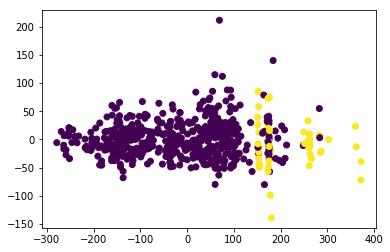

In [27]:
plt.scatter(X_train_pca[0], X_train_pca[1], c = y_train)

In [28]:
lr = LogisticRegression()
scores = cross_val_score(estimator = lr, X = X_train_pca, y = y_train, scoring = 'f1', cv = 5)
np.mean(scores)

C:\Users\Wojciech\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\Wojciech\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\Wojciech\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\Wojciech\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\Wojciech\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solv

0.5566666666666666

### LDA

In [0]:
lda = LDA(n_components = 3)

In [149]:
lda.fit(X_train, y_train)

/usr/local/lib/python3.6/dist-packages/sklearn/discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")


LinearDiscriminantAnalysis(n_components=3, priors=None, shrinkage=None,
              solver='svd', store_covariance=False, tol=0.0001)

In [0]:
X_train_lda = lda.transform(X_train)

In [151]:
X_train_lda = pd.DataFrame(X_train_lda)
X_train_lda.head()

,0
0,-0.321811
1,-1.812131
2,0.857852
3,-1.015937
4,-0.845091


#### Wizualizacja danych przy użyciu LDA

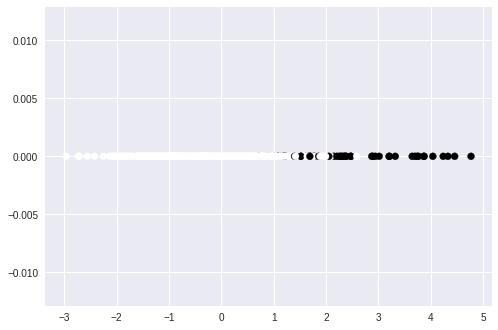

In [152]:
plt.scatter(X_train_lda, y = np.zeros(X_train_lda.size), c = y_train)

## Dobieranie hiperparametrów

Na przykładzie regresji logistycznej

In [29]:
lr = LogisticRegression()

lr_pipe = Pipeline([
    ('stdsc', StandardScaler()),
    ('pca', PCA(n_components = 0.95, svd_solver = 'full')),
    ('lr', lr)
])

param_grid = [
    {'lr__C': np.repeat(10.0,10) ** np.arange(-5,5)}
]

gs = GridSearchCV(estimator = lr_pipe,
                 param_grid = param_grid,
                 cv = 5,
                 scoring = 'f1',
                 n_jobs = -2)

gs.fit(X_train, y_train)

C:\Users\Wojciech\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
C:\Users\Wojciech\Anaconda3\lib\site-packages\sklearn\preprocessing\data.py:625: DataConversionWarning: Data with input dtype uint8, int64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
C:\Users\Wojciech\Anaconda3\lib\site-packages\sklearn\base.py:465: DataConversionWarning: Data with input dtype uint8, int64 were all converted to float64 by StandardScaler.
  return self.fit(X, y, **fit_params).transform(X)
C:\Users\Wojciech\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


GridSearchCV(cv=5, error_score='raise-deprecating',
       estimator=Pipeline(memory=None,
     steps=[('stdsc', StandardScaler(copy=True, with_mean=True, with_std=True)), ('pca', PCA(copy=True, iterated_power='auto', n_components=0.95, random_state=None,
  svd_solver='full', tol=0.0, whiten=False)), ('lr', LogisticRegression(C=1.0, class_weight=None, dual=...enalty='l2', random_state=None, solver='warn',
          tol=0.0001, verbose=0, warm_start=False))]),
       fit_params=None, iid='warn', n_jobs=-2,
       param_grid=[{'lr__C': array([1.e-05, 1.e-04, 1.e-03, 1.e-02, 1.e-01, 1.e+00, 1.e+01, 1.e+02,
       1.e+03, 1.e+04])}],
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='f1', verbose=0)

In [30]:
gs.best_estimator_

Pipeline(memory=None,
     steps=[('stdsc', StandardScaler(copy=True, with_mean=True, with_std=True)), ('pca', PCA(copy=True, iterated_power='auto', n_components=0.95, random_state=None,
  svd_solver='full', tol=0.0, whiten=False)), ('lr', LogisticRegression(C=0.001, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='warn',
          n_jobs=None, penalty='l2', random_state=None, solver='warn',
          tol=0.0001, verbose=0, warm_start=False))])

In [31]:
gs.param_grid

[{'lr__C': array([1.e-05, 1.e-04, 1.e-03, 1.e-02, 1.e-01, 1.e+00, 1.e+01, 1.e+02,
         1.e+03, 1.e+04])}]

In [32]:
gs.cv_results_

C:\Users\Wojciech\Anaconda3\lib\site-packages\sklearn\utils\deprecation.py:125: FutureWarning: You are accessing a training score ('split0_train_score'), which will not be available by default any more in 0.21. If you need training scores, please set return_train_score=True
  warnings.warn(*warn_args, **warn_kwargs)
C:\Users\Wojciech\Anaconda3\lib\site-packages\sklearn\utils\deprecation.py:125: FutureWarning: You are accessing a training score ('split1_train_score'), which will not be available by default any more in 0.21. If you need training scores, please set return_train_score=True
  warnings.warn(*warn_args, **warn_kwargs)
C:\Users\Wojciech\Anaconda3\lib\site-packages\sklearn\utils\deprecation.py:125: FutureWarning: You are accessing a training score ('split2_train_score'), which will not be available by default any more in 0.21. If you need training scores, please set return_train_score=True
  warnings.warn(*warn_args, **warn_kwargs)
C:\Users\Wojciech\Anaconda3\lib\site-packages\

{'mean_fit_time': array([0.09774275, 0.02651505, 0.02793512, 0.02468758, 0.02894645,
        0.02409425, 0.0283236 , 0.03929143, 0.047017  , 0.08808866]),
 'std_fit_time': array([0.04883238, 0.00486623, 0.0055422 , 0.00678775, 0.00629884,
        0.00320995, 0.00566321, 0.00386381, 0.00962049, 0.05753082]),
 'mean_score_time': array([0.03321462, 0.007234  , 0.00838971, 0.00610142, 0.00716076,
        0.00506353, 0.00480266, 0.00524445, 0.00606112, 0.00526357]),
 'std_score_time': array([0.01913745, 0.00270525, 0.00312474, 0.00158487, 0.00320205,
        0.00150435, 0.00074263, 0.00093503, 0.00310516, 0.00253362]),
 'param_lr__C': masked_array(data=[1e-05, 0.0001, 0.001, 0.01, 0.1, 1.0, 10.0, 100.0,
                    1000.0, 10000.0],
              mask=[False, False, False, False, False, False, False, False,
                    False, False],
        fill_value='?',
             dtype=object),
 'params': [{'lr__C': 1e-05},
  {'lr__C': 0.0001},
  {'lr__C': 0.001},
  {'lr__C': 0.01},
 

In [33]:
gs.best_params_

{'lr__C': 0.001}

In [98]:
gs.best_params_['lr__C']

0.001

In [34]:
lr_pipe = Pipeline([
    ('stdsc', StandardScaler()),
    ('pca', PCA(n_components = 0.95, svd_solver = 'full')),
    ('lr', LogisticRegression(C = 0.001))
])

## Predykcje

In [35]:
lr_pipe.fit(X_train, y_train)

C:\Users\Wojciech\Anaconda3\lib\site-packages\sklearn\preprocessing\data.py:625: DataConversionWarning: Data with input dtype uint8, int64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
C:\Users\Wojciech\Anaconda3\lib\site-packages\sklearn\base.py:465: DataConversionWarning: Data with input dtype uint8, int64 were all converted to float64 by StandardScaler.
  return self.fit(X, y, **fit_params).transform(X)
C:\Users\Wojciech\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


Pipeline(memory=None,
     steps=[('stdsc', StandardScaler(copy=True, with_mean=True, with_std=True)), ('pca', PCA(copy=True, iterated_power='auto', n_components=0.95, random_state=None,
  svd_solver='full', tol=0.0, whiten=False)), ('lr', LogisticRegression(C=0.001, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='warn',
          n_jobs=None, penalty='l2', random_state=None, solver='warn',
          tol=0.0001, verbose=0, warm_start=False))])

In [36]:
y_pred = lr_pipe.predict(X_test)

C:\Users\Wojciech\Anaconda3\lib\site-packages\sklearn\pipeline.py:331: DataConversionWarning: Data with input dtype uint8, int64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)


In [37]:
y_pred

array([False, False, False, False, False, False, False,  True, False,
       False, False, False, False, False, False, False, False,  True,
       False, False,  True, False,  True, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False,  True, False, False, False,  True, False, False,
       False, False, False, False, False, False, False, False,  True,
        True, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False,  True, False,  True,
       False,  True, False, False, False, False, False, False,  True,
       False,  True, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False,  True, False, False, False, False,  True,  True, False,
       False,  True, False, False, False, False, False, False, False,
        True, False,

In [38]:
(y_pred & y_test).sum() / y_pred.sum() # precyzja

0.5

In [39]:
(y_pred & y_test).sum() / y_test.sum()

0.8125

## Confusion matrix

In [40]:
cm = confusion_matrix(y_true = y_test, y_pred = y_pred)

In [41]:
cm

array([[171,  13],
       [  3,  13]], dtype=int64)

Text(0,0.5,'actual')

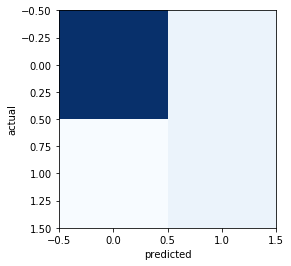

In [43]:
plt.imshow(cm, interpolation='nearest',cmap=plt.cm.Blues)
plt.xlabel("predicted")
plt.ylabel("actual")

In [49]:
y_pred_proba = lr_pipe.predict_proba(X_test)

C:\Users\Wojciech\Anaconda3\lib\site-packages\sklearn\pipeline.py:381: DataConversionWarning: Data with input dtype uint8, int64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)


In [50]:
y_pred_proba = y_pred_proba[:,1]

In [70]:
y_pred_02 = y_pred_proba>=0.55

In [71]:
cm = confusion_matrix(y_true = y_test, y_pred = y_pred_02)
cm

array([[181,   3],
       [ 11,   5]], dtype=int64)

Text(0,0.5,'actual')

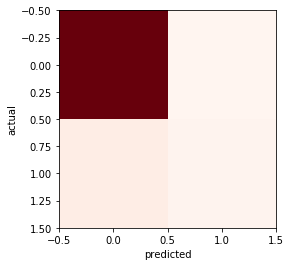

In [72]:
plt.imshow(cm, interpolation='nearest',cmap=plt.cm.Reds)
plt.xlabel("predicted")
plt.ylabel("actual")

## Sprawdzian krzyżowy
### Przy użyciu StratifiedKFold

In [120]:
skf = SKF(n_splits=5)

In [121]:
ind = skf.split(X_train, y_train)

Zbiór: 0
1.0
0.5
Zbiór: 1


C:\Users\Wojciech\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
C:\Users\Wojciech\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\Wojciech\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\Wojciech\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\Wojciech\Anaconda3\lib\site-packages\sklearn\linear_model\l

0.6666666666666666
0.5454545454545454
Zbiór: 2
0.6666666666666666
0.6
Zbiór: 3


C:\Users\Wojciech\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
C:\Users\Wojciech\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\Wojciech\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\Wojciech\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\Wojciech\Anaconda3\lib\site-packages\sklearn\linear_model\l

0.8
0.8888888888888888
Zbiór: 4
0.8571428571428571
0.5454545454545454


C:\Users\Wojciech\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\Wojciech\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


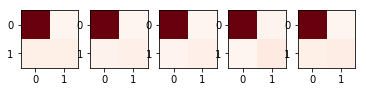

In [122]:
ind = skf.split(X_train, y_train)
fig, ax = plt.subplots(1,5)

lr = LogisticRegression()

param_grid = [
    {'C': np.repeat(10.0,5) ** np.arange(-2,3)}
]

lr_gs = GridSearchCV(estimator=lr,
                        cv=2,
                        param_grid = param_grid,
                        n_jobs=-2,
                        scoring='f1')

for k, (train, test) in enumerate(ind):
    
    print(str.format('Zbiór: {0}', k))
    
    lr_gs.fit(np.array(X_train.iloc[train,:]), np.array(y_train.iloc[train]))
    
    C = lr_gs.best_params_['C']
    
    lr.set_params(**{'C': C})
    
    lr.fit(X_train.iloc[train,:], y_train.iloc[train])
    y_pred = lr.predict(X_train.iloc[test,:])
    
    print((y_pred & y_train.iloc[test]).sum() / y_pred.sum())
    print((y_pred & y_train.iloc[test]).sum() / y_train.iloc[test].sum())
    
    cm = confusion_matrix(y_pred=y_pred, y_true=y_train.iloc[test])
    
    ax[k].imshow(cm, interpolation = 'nearest', cmap=plt.cm.Reds)
    

In [106]:
pd.DataFrame(y_train).isna().sum()

Legendary    0
dtype: int64

In [108]:
np.array(y_train)

array([False, False, False,  True, False, False, False, False, False,
       False, False, False, False,  True, False, False, False, False,
       False, False, False, False,  True, False, False, False,  True,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False,  True, False, False,  True, False, False, False, False,
       False, False, False, False,  True, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False,  True, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False,

In [118]:
y_test

185    False
143    False
95     False
555    False
91     False
357    False
344    False
409    False
115    False
307    False
371    False
626    False
699     True
506    False
618    False
182    False
336    False
339    False
24     False
694    False
8      False
139    False
712     True
414     True
676    False
242    False
179    False
216    False
679    False
749    False
       ...  
229    False
750    False
167    False
483    False
757    False
296    False
453    False
608    False
152    False
780    False
708     True
734    False
789    False
18     False
544     True
156     True
184    False
253    False
331    False
452    False
563    False
241    False
398    False
722    False
792     True
548    False
49     False
487    False
236    False
526    False
Name: Legendary, Length: 200, dtype: bool